In [1]:
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from _modules.search import PSOSearchCV_SVM
import numpy as np

# Set format of numpy array#
np.set_printoptions(precision=4, suppress=True)

# Import data

In [2]:
# Use UCI ML hand-written digits datasets, for digit = 2 or 3
X, y = load_digits(return_X_y=True)
X = X[(y == 2) | (y == 3)]
y = y[(y == 2) | (y == 3)]

# Add noise to X
X = X + np.random.normal(loc=0,scale=12,size=X.shape)
X[X < 0] = 0
X[X > 16] = 16
X = X.astype(int)

# Train Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=2021)
scaler = StandardScaler().fit(X_train)
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

# Classification by default parameters

In [3]:
# Fit SVM classifier
clf_default = SVC(kernel='rbf')
clf_default.fit(X_train, y_train)
print('(Cross Validation) AUC Score:', np.mean(cross_val_score(estimator=clf_default, X=X_train, y=y_train, cv=5, scoring='roc_auc')))

# Show result
print('(Test set) Confusion Matrix:')
print(confusion_matrix(y_test, clf_default.predict(X_test)))
print('(Test set) AUC Score:', roc_auc_score(y_test, clf_default.predict(X_test)))

(Cross Validation) AUC Score: 0.8556810256410255
(Test set) Confusion Matrix:
[[36 17]
 [ 9 46]]
(Test set) AUC Score: 0.7578044596912523


# Classification by parameters from PSO

In [4]:
# Set parameters
C_range = [0.5, 2]
gamma_range = [0.001, 10]
para = {'C': C_range, 'gamma': gamma_range}

# Get best parameters for PSO 
# Note that PSOSearchCV return to objects:
#   clf.result:        Cross validation Score for different combination of C and gamma in every iteration
#   clf.best_param:    Best parameters
para_pso = PSOSearchCV_SVM(estimator=SVC(kernel='rbf'), param_grid=para, scoring='roc_auc',
                           cv=5, n_jobs=3, verbose=False,       # n_job for cv-score computation. NOT for searching
                           pso_size=200, pso_max_iter=8, velocity_scale=.5)
para_pso.fit(X_train, y_train)
print('Best parameters:', para_pso.best_param)

Best parameters: {'C': 0.7726859318415608, 'gamma': 0.0012045606715699803, 'score': 0.8682743589743589}


In [5]:
# Fit SVM classifier
clf_pso = SVC(kernel='rbf', C=para_pso.best_param['C'], gamma=para_pso.best_param['gamma'])
clf_pso.fit(X_train, y_train)
print('(Cross Validation) AUC Score:', np.mean(cross_val_score(estimator=clf_pso, X=X_train, y=y_train, cv=5, scoring='roc_auc')))

# Show result
print('(Test set) Confusion Matrix:')
print(confusion_matrix(y_test, clf_pso.predict(X_test)))
print('(Test set) AUC Score:', roc_auc_score(y_test, clf_pso.predict(X_test)))

(Cross Validation) AUC Score: 0.8682743589743589
(Test set) Confusion Matrix:
[[39 14]
 [11 44]]
(Test set) AUC Score: 0.7679245283018868


# Visualize Cross validation Score for different combination of C and gamma

In [6]:
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
# Show result of last iteration
result_pd_final = pd.DataFrame.from_dict(para_pso.result[-1])
print(f'Range of final iteration: "C" ({np.min(result_pd_final["C"])}, {np.max(result_pd_final["C"])})')
print(f'Range of final iteration: "gamma" ({np.min(result_pd_final["gamma"])}, {np.max(result_pd_final["gamma"])})')
result_pd_final

Range of final iteration: "C" (0.6063723165309536, 1.4640286110617091)
Range of final iteration: "gamma" (0.001, 6.006611497894516)


,C,gamma,score,velocity
0,0.811227,0.001763,0.864813,"[-0.01029782122451442, -0.0001497370183579602]"
1,0.773116,0.001496,0.866992,"[-0.0003103736240272643, -0.00015128457325697592]"
2,0.769915,0.001209,0.868274,"[0.007778294284134262, -6.498181968468539e-06]"
3,0.785220,2.273486,0.500000,"[-0.006737218443892443, -1.1981408927278627]"
4,0.811909,0.025948,0.851651,"[-0.006789593167128305, -0.004242231813654905]"
...,...,...,...,...
195,0.903814,0.001917,0.864493,"[0.010837646313388412, 5.7635703987529566e-05]"
196,0.755399,0.001359,0.867954,"[0.004390441760215363, -3.8891557409443734e-05]"
197,0.772935,0.001000,0.866674,"[-0.0002241042497943776, -4.348935877399623e-05]"
198,0.771728,0.001000,0.866674,"[-0.0002370513158916811, -0.006740279106824262]"


In [8]:
np.min(result_pd_final['C'])

0.6063723165309536

In [9]:
# Flatten result from all iteration
result_pso = {'C': [], 'gamma': [], 'score': []}

for i in range(0, len(para_pso.result)):
    for j in range(0, len(para_pso.result[0]['C'])):
        result_pso['C'].append(para_pso.result[i]['C'][j])
        result_pso['gamma'].append(para_pso.result[i]['gamma'][j])
        result_pso['score'].append(para_pso.result[i]['score'][j])

result_pso['C'] = np.round(result_pso['C'], 6)
result_pso['gamma'] = np.round(result_pso['gamma'], 6)
result_pso['score'] = np.round(result_pso['score'], 6)

In [10]:
# Create data matrix for N*N heatmap:   Set size
heatmap_size = 80

# Create data matrix for N*N heatmap:   Set axis
x_pos = np.logspace(start=np.log10(C_range[0]), stop=np.log10(C_range[1]), num=heatmap_size)
y_pos = np.logspace(start=np.log10(gamma_range[0]), stop=np.log10(gamma_range[1]), num=heatmap_size)
matrix_pso = np.zeros(shape=(y_pos.shape[0], x_pos.shape[0]))

# Create data matrix for N*N heatmap:   Set values
for c in range(0, len(result_pso['score'])):
    i = np.where(x_pos >= result_pso['C'][c])[0]
    if (len(i) > 1):
        i = i[0]
    j = np.where(y_pos >= result_pso['gamma'][c])[0]
    if (len(j) > 1):
        j = j[0]
    matrix_pso[i, j] = np.maximum(matrix_pso[i, j], result_pso['score'][c])

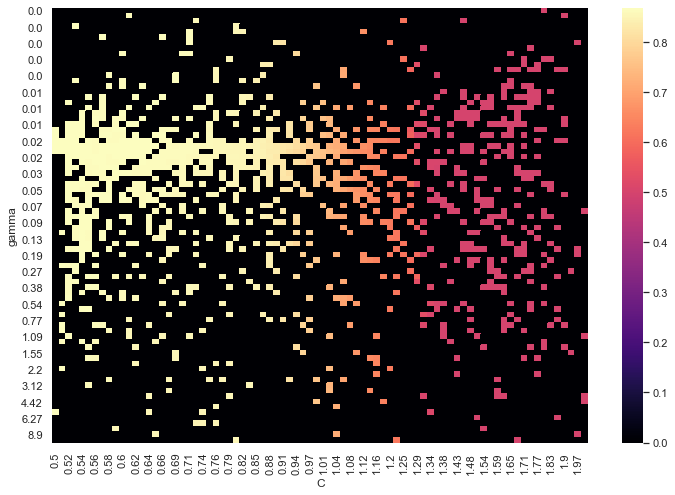

In [13]:
# Plot heatmap
x_pos = np.round(x_pos, 2)
y_pos = np.round(y_pos, 2)
df_pso = pd.DataFrame(matrix_pso, columns=x_pos, index=y_pos)
sns.set_theme()
plt.figure(figsize=(12,8))
ax = sns.heatmap(df_pso, cmap='magma', vmax=np.max(result_pso['score']))
plt.xlabel('C')
plt.ylabel('gamma')
plt.show()